In [1]:
import torch, torchvision
from torch import nn
import numpy as np
import torch.nn.functional as F

In [2]:
# Data
IMAGE_SIZE = (100, 100)

# ENV
DEVICE = "cuda:4" if torch.cuda.is_available() else "cpu"
LATENT_DIM = 500

# TRAIN
BATCH_SIZE = 512
EPOCHS = 50
LR = 1e-3

## Data

### Setup dataloader

In [3]:
import torchvision.transforms as T
import os
from PIL import Image

transform = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
])

class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, paths, transform):
        self.file_paths = []
        
        for path in paths:
            for file_name in os.listdir(path):
                self.file_paths.append(f"{path}/{file_name}")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        image = Image.open(self.file_paths[idx])
        return transform(image)

celeb_a_dataset = CelebADataset(paths=["../data/celeb_a/00",
                                       "../data/celeb_a/01"],
                                transform=transform)

celeb_a_dataloader = torch.utils.data.DataLoader(celeb_a_dataset,
                                                 shuffle=True,
                                                 batch_size=BATCH_SIZE)

### plot samples

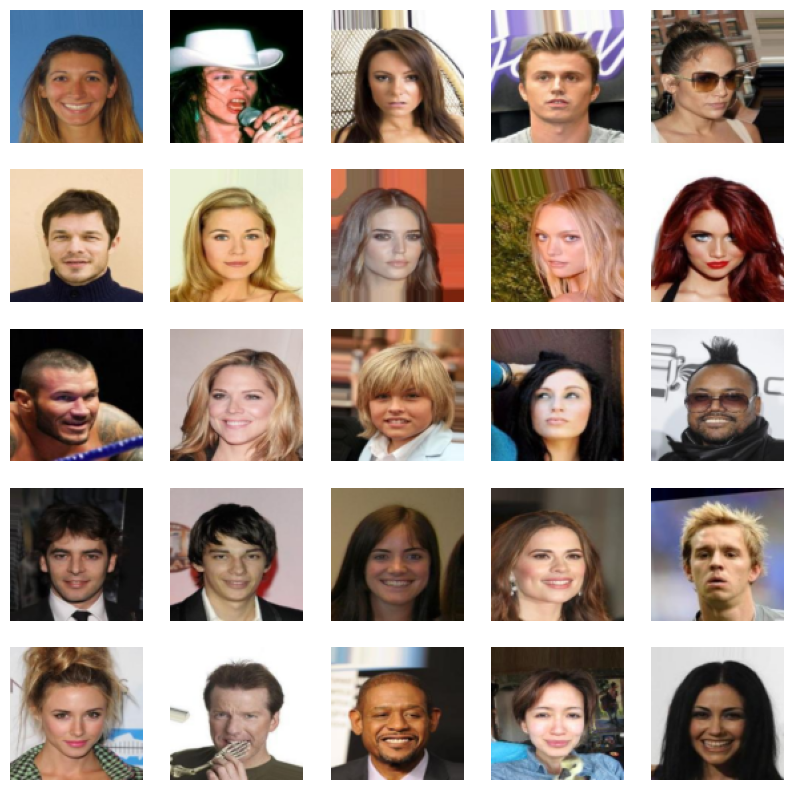

In [4]:
import matplotlib.pyplot as plt

def tensor_to_pil_image(tensor_image):
    tensor_image = tensor_image * 255
    np_image = tensor_image.detach().numpy().transpose(1,2,0).astype(np.uint8)
    return Image.fromarray(np_image)

# plot
plt.figure(figsize=(10,10))
for i, image in enumerate(iter(celeb_a_dataset)):
    image = tensor_to_pil_image(image)
    
    plt.subplot(5,5,i+1)
    plt.imshow(image)
    plt.axis("off")
    if i == 24:
        break

## Model

In [5]:
from torchsummary import summary

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.conv_layer = nn.Sequential(
            self.__encoder_module(3, 32),
            self.__encoder_module(32, 64),
            self.__encoder_module(64, 128),
            self.__encoder_module(128, 256),
            self.__encoder_module(256, 512),
        )
        self.layer_flatten = nn.Flatten(start_dim=1) # batch 제외
        self.layer_mean = nn.Linear(512*4*4, latent_dim) # 3x150x150 -> 512x4x4
        self.layer_log_var = nn.Linear(512*4*4, latent_dim)
        
    def __encoder_module(self, in_channel, out_channel):
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel,
                      kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        assert tuple(x.shape[-2:]) == IMAGE_SIZE

        x = self.conv_layer(x)
        x = self.layer_flatten(x)
        mean = self.layer_mean(x)
        log_var = self.layer_log_var(x)
        return mean, log_var

encoder = Encoder(latent_dim=LATENT_DIM)
summary(encoder, input_size=(3,100,100), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]             896
       BatchNorm2d-2           [-1, 32, 50, 50]              64
         LeakyReLU-3           [-1, 32, 50, 50]               0
            Conv2d-4           [-1, 64, 25, 25]          18,496
       BatchNorm2d-5           [-1, 64, 25, 25]             128
         LeakyReLU-6           [-1, 64, 25, 25]               0
            Conv2d-7          [-1, 128, 13, 13]          73,856
       BatchNorm2d-8          [-1, 128, 13, 13]             256
         LeakyReLU-9          [-1, 128, 13, 13]               0
           Conv2d-10            [-1, 256, 7, 7]         295,168
      BatchNorm2d-11            [-1, 256, 7, 7]             512
        LeakyReLU-12            [-1, 256, 7, 7]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-14            [-1, 51

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.inputs = nn.Linear(latent_dim, 512*4*4)
        self.linear_to_conv = lambda x: x.view(-1, 512, 4, 4)
        self.conv_layer = nn.Sequential(
            self.__decoder_modules(512, 256, output_padding=0),
            self.__decoder_modules(256, 128, output_padding=0),
            self.__decoder_modules(128, 64, output_padding=0),
            self.__decoder_modules(64, 32),
        )
        self.output_layer = nn.ConvTranspose2d(32, 3,
                                               kernel_size=3, stride=2, 
                                               padding=1, output_padding=1)
    
    def __decoder_modules(self, in_channel, out_channel, output_padding=1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel,
                               kernel_size=3, stride=2, 
                               padding=1, output_padding=output_padding),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(),
        )

    def forward(self, z):
        assert z.shape[-1] == self.latent_dim

        outputs = self.inputs(z)
        outputs = self.linear_to_conv(outputs)
        outputs = self.conv_layer(outputs)
        outputs = self.output_layer(outputs)
        return outputs

decoder = Decoder(latent_dim=LATENT_DIM)
summary(decoder, input_size=(LATENT_DIM,), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 8192]       4,104,192
   ConvTranspose2d-2            [-1, 256, 7, 7]       1,179,904
       BatchNorm2d-3            [-1, 256, 7, 7]             512
         LeakyReLU-4            [-1, 256, 7, 7]               0
   ConvTranspose2d-5          [-1, 128, 13, 13]         295,040
       BatchNorm2d-6          [-1, 128, 13, 13]             256
         LeakyReLU-7          [-1, 128, 13, 13]               0
   ConvTranspose2d-8           [-1, 64, 25, 25]          73,792
       BatchNorm2d-9           [-1, 64, 25, 25]             128
        LeakyReLU-10           [-1, 64, 25, 25]               0
  ConvTranspose2d-11           [-1, 32, 50, 50]          18,464
      BatchNorm2d-12           [-1, 32, 50, 50]              64
        LeakyReLU-13           [-1, 32, 50, 50]               0
  ConvTranspose2d-14          [-1, 3, 1

In [7]:
class VAE(nn.Module):
    @staticmethod
    def create(latent_dim):
        encoder = Encoder(latent_dim)
        decoder = Decoder(latent_dim)
        return VAE(encoder, decoder)

    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        x_prime = self.decoder(z)
        return x_prime, mean, log_var
    
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return epsilon*std + mean

    # utils
    def save(self, path):
        torch.save(self.state_dict(), path)

    @staticmethod
    def load(latent_dim, path):
        vae = VAE.create(latent_dim)
        vae.load_state_dict(torch.load(path))
        return vae

vae = VAE.create(latent_dim=LATENT_DIM)
summary(vae, input_size=(3,100,100), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]             896
       BatchNorm2d-2           [-1, 32, 50, 50]              64
         LeakyReLU-3           [-1, 32, 50, 50]               0
            Conv2d-4           [-1, 64, 25, 25]          18,496
       BatchNorm2d-5           [-1, 64, 25, 25]             128
         LeakyReLU-6           [-1, 64, 25, 25]               0
            Conv2d-7          [-1, 128, 13, 13]          73,856
       BatchNorm2d-8          [-1, 128, 13, 13]             256
         LeakyReLU-9          [-1, 128, 13, 13]               0
           Conv2d-10            [-1, 256, 7, 7]         295,168
      BatchNorm2d-11            [-1, 256, 7, 7]             512
        LeakyReLU-12            [-1, 256, 7, 7]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-14            [-1, 51

## Train

In [8]:
def loss_fn(x, x_prime, mean, log_var):
    reconstruction_loss = F.mse_loss(x_prime, x, reduction="sum")
    kld = -0.5 * torch.sum(1 + log_var - mean**2 - log_var.exp())
    return reconstruction_loss + kld

In [9]:
from tqdm import tqdm

optimizer = torch.optim.Adam(vae.parameters(), lr=LR)

vae.to(DEVICE)
vae.train()

for epoch in tqdm(range(EPOCHS), desc="Epoch", position=0):
    for x in tqdm(celeb_a_dataloader, desc="Batch", position=0, leave=False):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        
        x_prime, mean, log_var = vae(x)
        loss = loss_fn(x, x_prime, mean, log_var)
        loss.backward()
        optimizer.step()
        
    print(f"loss: {loss.item()}")
        

Epoch:   2%|▏         | 1/50 [00:15<12:39, 15.49s/it] 

loss: 47126.03515625


Epoch:   4%|▍         | 2/50 [00:30<12:01, 15.03s/it] 

loss: 36632.71484375


Epoch:   6%|▌         | 3/50 [00:44<11:40, 14.90s/it] 

loss: 32204.91796875


Epoch:   8%|▊         | 4/50 [00:59<11:21, 14.83s/it] 

loss: 35232.66796875


Epoch:  10%|█         | 5/50 [01:14<11:07, 14.83s/it] 

loss: 27316.826171875


Epoch:  12%|█▏        | 6/50 [01:29<10:48, 14.73s/it] 

loss: 24270.0


Epoch:  14%|█▍        | 7/50 [01:43<10:35, 14.77s/it] 

loss: 22018.900390625


Epoch:  16%|█▌        | 8/50 [01:58<10:18, 14.73s/it] 

loss: 18799.84765625


Epoch:  18%|█▊        | 9/50 [02:13<10:01, 14.67s/it] 

loss: 20649.42578125


Epoch:  20%|██        | 10/50 [02:27<09:47, 14.68s/it]

loss: 18484.77734375


Epoch:  22%|██▏       | 11/50 [02:42<09:30, 14.62s/it]

loss: 20638.78125


Epoch:  24%|██▍       | 12/50 [02:57<09:19, 14.71s/it]

loss: 21608.466796875


Epoch:  26%|██▌       | 13/50 [03:12<09:08, 14.82s/it]

loss: 15288.568359375


Epoch:  28%|██▊       | 14/50 [03:27<08:56, 14.89s/it]

loss: 16671.9140625


Epoch:  30%|███       | 15/50 [03:42<08:41, 14.91s/it]

loss: 17027.31640625


Epoch:  32%|███▏      | 16/50 [03:57<08:26, 14.90s/it]

loss: 17358.99609375


Epoch:  34%|███▍      | 17/50 [04:11<08:10, 14.86s/it]

loss: 29900.87109375


Epoch:  36%|███▌      | 18/50 [04:27<07:58, 14.95s/it]

loss: 18222.181640625


Epoch:  38%|███▊      | 19/50 [04:42<07:44, 14.99s/it]

loss: 16271.7392578125


Epoch:  40%|████      | 20/50 [04:57<07:28, 14.96s/it]

loss: 16531.814453125


Epoch:  42%|████▏     | 21/50 [05:11<07:12, 14.90s/it]

loss: 17830.76171875


Epoch:  44%|████▍     | 22/50 [05:26<06:52, 14.72s/it]

loss: 16089.15234375


Epoch:  46%|████▌     | 23/50 [05:41<06:39, 14.78s/it]

loss: 17554.169921875


Epoch:  48%|████▊     | 24/50 [05:56<06:26, 14.88s/it]

loss: 13932.244140625


Epoch:  50%|█████     | 25/50 [06:10<06:11, 14.87s/it]

loss: 14743.1669921875


Epoch:  52%|█████▏    | 26/50 [06:26<05:58, 14.92s/it]

loss: 15069.2568359375


Epoch:  54%|█████▍    | 27/50 [06:41<05:43, 14.95s/it]

loss: 19275.3828125


Epoch:  56%|█████▌    | 28/50 [06:55<05:25, 14.79s/it]

loss: 15757.126953125


Epoch:  58%|█████▊    | 29/50 [07:10<05:12, 14.90s/it]

loss: 15380.58984375


Epoch:  60%|██████    | 30/50 [07:25<04:58, 14.91s/it]

loss: 14525.33203125


Epoch:  62%|██████▏   | 31/50 [07:40<04:44, 14.97s/it]

loss: 12495.3828125


Epoch:  64%|██████▍   | 32/50 [07:55<04:29, 14.97s/it]

loss: 14874.5458984375


Epoch:  66%|██████▌   | 33/50 [08:10<04:12, 14.87s/it]

loss: 14767.673828125


Epoch:  68%|██████▊   | 34/50 [08:25<03:58, 14.88s/it]

loss: 13391.869140625


Epoch:  70%|███████   | 35/50 [08:39<03:42, 14.85s/it]

loss: 18202.41015625


Epoch:  72%|███████▏  | 36/50 [08:54<03:28, 14.88s/it]

loss: 17007.283203125


Epoch:  74%|███████▍  | 37/50 [09:09<03:11, 14.76s/it]

loss: 33244.29296875


Epoch:  76%|███████▌  | 38/50 [09:24<02:57, 14.83s/it]

loss: 12514.04296875


Epoch:  78%|███████▊  | 39/50 [09:39<02:44, 14.91s/it]

loss: 13148.671875


Epoch:  80%|████████  | 40/50 [09:54<02:28, 14.88s/it]

loss: 15018.8447265625


Epoch:  82%|████████▏ | 41/50 [10:09<02:14, 14.96s/it]

loss: 21429.29296875


Epoch:  84%|████████▍ | 42/50 [10:24<01:59, 14.98s/it]

loss: 12432.17578125


Epoch:  86%|████████▌ | 43/50 [10:39<01:45, 15.12s/it]

loss: 14789.337890625


Epoch:  88%|████████▊ | 44/50 [10:55<01:30, 15.15s/it]

loss: 23611.9140625


Epoch:  90%|█████████ | 45/50 [11:10<01:15, 15.13s/it]

loss: 13683.453125


Epoch:  92%|█████████▏| 46/50 [11:24<00:59, 14.96s/it]

loss: 13459.375


Epoch:  94%|█████████▍| 47/50 [11:39<00:44, 14.98s/it]

loss: 14096.287109375


Epoch:  96%|█████████▌| 48/50 [11:54<00:30, 15.02s/it]

loss: 14907.9609375


Epoch:  98%|█████████▊| 49/50 [12:09<00:14, 15.00s/it]

loss: 12180.01171875


Epoch: 100%|██████████| 50/50 [12:24<00:00, 14.90s/it]

loss: 12777.9287109375


In [10]:
vae.save(path=f"vae_celeb_a_{LATENT_DIM}_dim.pt")

## Inference

In [11]:
vae = VAE.load(latent_dim=LATENT_DIM, path=f"vae_celeb_a_{LATENT_DIM}_dim.pt")
vae.to(DEVICE)
vae.eval()

VAE(
  (encoder): Encoder(
    (conv_layer): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

### Reconstruct input images

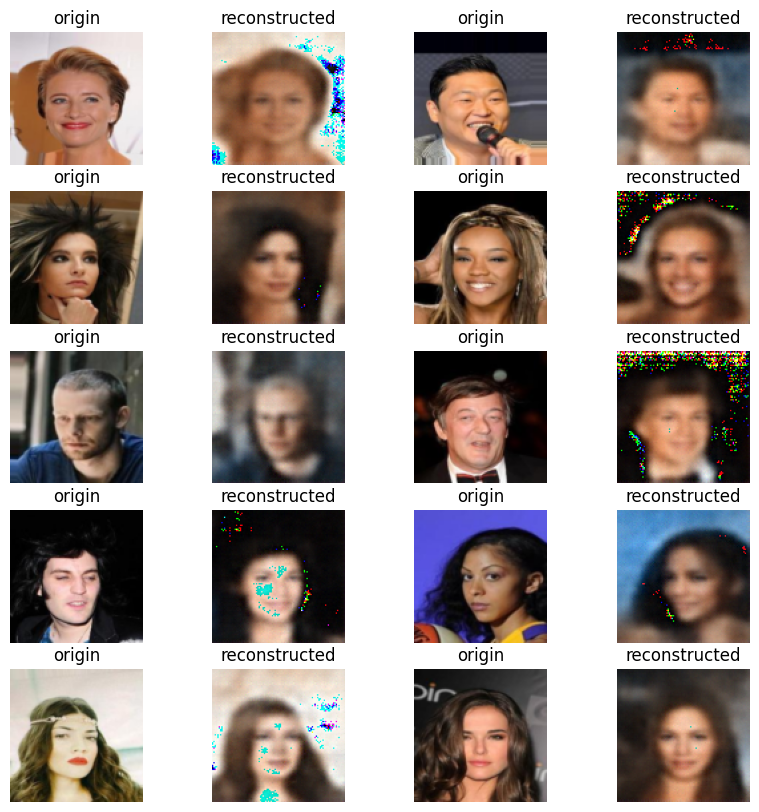

In [14]:
sample_dataloader = torch.utils.data.DataLoader(celeb_a_dataset,
                                                shuffle=True,
                                                batch_size=10)
sample_images = next(iter(sample_dataloader)).to(DEVICE)
x_prime, mean, log_var = vae(sample_images)

plt.figure(figsize=(10,10))
for i, (origin_image, reconstructed_image) in enumerate(zip(sample_images, x_prime)):
    reconstructed_image = reconstructed_image.to("cpu")
    reconstructed_image = tensor_to_pil_image(reconstructed_image)
    
    origin_image = origin_image.to("cpu")
    origin_image = tensor_to_pil_image(origin_image)

    plt.subplot(5,4,2*i+1)
    plt.imshow(origin_image)
    plt.title("origin")
    plt.axis("off")

    plt.subplot(5,4,2*i+2)
    plt.imshow(reconstructed_image)
    plt.title("reconstructed")
    plt.axis("off")


### Generate sample images

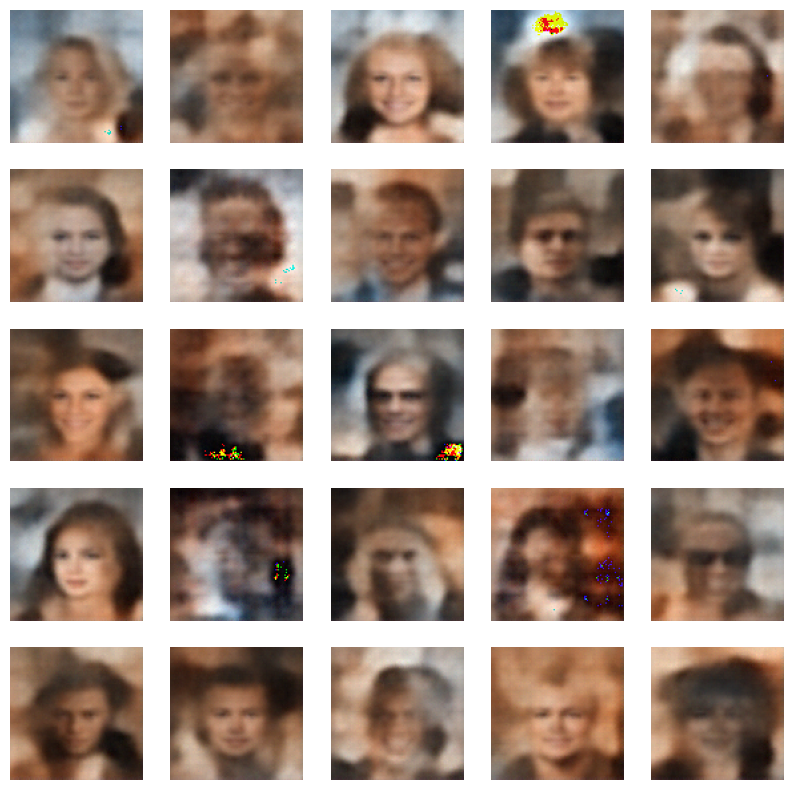

In [13]:
sample_z = torch.randn((25, LATENT_DIM)).to(DEVICE)

plt.figure(figsize=(10,10))
for i, generated_image in enumerate(vae.decoder(sample_z)):
    generated_image = generated_image.to("cpu")
    generated_image = tensor_to_pil_image(generated_image)
    
    plt.subplot(5,5,i+1)
    plt.imshow(generated_image)
    plt.axis("off")